In [ ]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379363 sha256=ff690fa7f364970eb4f45e60ab1aab02814e44c6f5f8ab5d363ef940c81eede5
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
!pip install imageio

In [ ]:
import math
import random
import cv2
import gymnasium as gym
import imageio

import numpy as np
import time
import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
from IPython.display import clear_output
import matplotlib.pyplot as plt

from collections import deque

In [ ]:
device = torch.device(0 if torch.cuda.is_available() else "cpu")

In [ ]:
# Network Architecture|
class ImpalaCnn64(nn.Module):
    def __init__(self, in_channels, num_outputs, base_channels=16):
        super(ImpalaCnn64, self).__init__()
        self.conv_block1 = nn.Conv2d(in_channels, base_channels, 3, 4, 0)
        self.conv_block2 = nn.Conv2d(base_channels, 2*base_channels, 3, 2, 0)

        flatten = 2*base_channels*7*7
        self.fc1 = nn.Linear(flatten, 256)
        self.actor = nn.Linear(256, num_outputs)
        self.critic = nn.Linear(256, 1)
        self.relu = nn.ReLU()

    def forward(self, x):

        x = F.relu(self.conv_block1(x))  # [B,1,64,64] -> [B,16, h, w]
        x = F.relu(self.conv_block2(x))  # [B,16,h,w]  -> [B,32,h,w]
        x = x.reshape(x.size(0), -1)     # [B,32*h*w]
        x = self.relu(self.fc1(x))       # [B,256]

        #critic
        value = self.critic(x)           # [B,1]

        # Actor
        dist = Categorical(logits=self.actor(x)) #[B,5]

        return dist, value

In [ ]:
def set_seed(seed, env):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    env.action_space.seed(seed)

In [ ]:
#buffer
class ReplayBuffer:
    def __init__(self, data_names, buffer_size, mini_batch_size, device):
        self.data_keys = data_names


        # {'states': deque(...), 'actions': deque(...)}
        self.data_dict = {}

        self.buffer_size = buffer_size
        self.mini_batch_size = mini_batch_size
        self.device = device

        self.reset()

    def reset(self):

        # Each key ko deque banako
        for name in self.data_keys:
            self.data_dict[name] = deque(maxlen=self.buffer_size)

    def buffer_full(self):
        return len(self.data_dict[self.data_keys[0]]) == self.buffer_size

    def data_log(self, data_name, data):   # collect data and add

        data = data.cpu().split(1)
        self.data_dict[data_name].extend(data)

    def __iter__(self):


        batch_size = len(self.data_dict[self.data_keys[0]])
        batch_size = batch_size - batch_size % self.mini_batch_size


        ids = np.random.permutation(batch_size)
        ids = np.split(ids, batch_size // self.mini_batch_size)


        for i in range(len(ids)):

            batch_dict = {}

            for name in self.data_keys:
                c = [self.data_dict[name][j] for j in ids[i]]
                batch_dict[name] = torch.cat(c).to(self.device)


            batch_dict["batch_size"] = len(ids[i])
            yield batch_dict

    def __len__(self):
        return len(self.data_dict[self.data_keys[0]])

In [ ]:
def state_to_tensor(obs, device, resize_shape=(64, 64)): #[96,96,3]
  obs = cv2.resize(obs, resize_shape, interpolation=cv2.INTER_LINEAR)
  obs = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
  obs = obs / 255.
  obs = torch.tensor(obs, dtype=torch.float32, device = device)
  return obs.unsqueeze(0)  #[64,64]

def tensor_to_unit8(tesnor):
    numpy_float = tesnor.squeeze(0).cpu().numpy().transpose((1, 2, 0))
    return (numpy_float * 255).astype(np.uint8)

def evaluate_agent(env, rl_model, device, n_episodes=3):

    # run 3 episodes, return average score.
    rl_model.eval()
    total_rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            state = state_to_tensor(obs, device).unsqueeze(0)
            with torch.no_grad():
                dist, _ = rl_model(state)
                # do i need to add stocasticity here? is sampling better?
                action = torch.argmax(dist.probs).item()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        total_rewards.append(episode_reward)
    rl_model.train()  # not needed
    return np.mean(total_rewards)

In [ ]:
def ppo_loss(new_dist, actions, old_log_probs, advantages, clip_param): # input: new_dist, model update vaepaxi ko [MB,5](categorical)

    new_log_probs = new_dist.log_prob(actions)  # [MB] hamro action ko log prob. on new dist.
    ratio = (new_log_probs - old_log_probs).exp()
    surr1 = ratio * advantages                  # [MB]
    surr2 = torch.clamp(ratio, 1.0 - clip_param, 1.0 + clip_param) * advantages
    actor_loss = torch.min(surr1, surr2)        # [MB]
    return actor_loss.mean()


In [ ]:
def clipped_critic_loss(new_value, old_value, returns, clip_param):
    vf_loss1 = (new_value - returns).pow(2.)
    vpredclipped = old_value + torch.clamp(new_value - old_value, -clip_param, clip_param)
    vf_loss2 = (vpredclipped - returns).pow(2.)
    critic_loss = torch.max(vf_loss1, vf_loss2)
    return critic_loss.mean()

In [ ]:
def compute_gae(next_value, rewards, masks, values, gamma=0.999, tau=0.95): # input -> reward[1000,1]
    gae = 0
    returns = deque()
    gae_logger = deque()

    for step in reversed(range(len(rewards))):

        delta = rewards[step] + gamma * next_value * masks[step] - values[step]


        gae = delta + gamma * tau * masks[step] * gae
        next_value = values[step]
        returns.appendleft(gae + values[step])
        gae_logger.appendleft(gae)

    return returns, gae_logger

In [ ]:
def ppo_update(data_buffer, ppo_epochs, clip_param, rl_model, optimizer):  #input # databuffer vitra state : [1000,1,64,64]
    for _ in range(ppo_epochs):
        for data_batch in data_buffer:

            new_dist, new_value = rl_model(data_batch["states"]) #[MB,5] & [MB,1]  #i think gradient updates happens here, from loss.
            entropy = new_dist.entropy().mean()

            actor_loss = ppo_loss(new_dist, data_batch["actions"], data_batch["log_probs"], data_batch["advantages"],  # input: new_dist, model update vaepaxi ko [MB,5](categorical)
                                  clip_param)

            critic_loss = clipped_critic_loss(new_value, data_batch["values"], data_batch["returns"], clip_param) #input: new values [MB,1]

            agent_loss = critic_loss - actor_loss - 0.01 * entropy   #alpha * entropy, (encourage exploraton)

            # what if agent_loss = critic_loss - actor_loss - alpha*(entropy(state_visit_distribution))?

            optimizer.zero_grad()
            agent_loss.backward()
            nn.utils.clip_grad_norm_(rl_model.parameters(), 40)
            optimizer.step()

In [ ]:
# torch1 = torch.ones(10,5)
# dist = Categorical(torch.tensor(torch1))
# dist.entropy().mean()
# dist = Categorical(torch.tensor([[0,0,0,0,1]]))
# log_prob = dist.log_prob(torch.tensor([3]))
# print(log_prob)

In [ ]:
seeds = [42, 123]

# Training parameters
max_frames = 25000
lr = 5e-4
num_steps = 256
ppo_epochs = 4
num_mini_batch = 8
eval_interval = 5

# PPO parameters
gamma = 0.99
tau = 0.95
clip_param = 0.2

# Buffer and data storage
buffer_size = num_steps
mini_batch_size = buffer_size // num_mini_batch
all_runs_rewards = []
all_runs_frames = []

In [ ]:
# 1000 = 2048*8
env_name = 'CarRacing-v3'

In [ ]:
for seed in seeds:

  print(f" training for seed: {seed} ")
  env = gym.make(env_name, render_mode="rgb_array", lap_complete_percent=0.95, domain_randomize=False, continuous=False)
  set_seed(seed, env)

  rl_model = ImpalaCnn64(1, 5).to(device)
  optimizer = optim.Adam(rl_model.parameters(), lr=lr)

  data_names = ["states", "actions", "log_probs", "values", "returns", "advantages"]
  data_buffer = ReplayBuffer(data_names, buffer_size, mini_batch_size, device)
  frames_seen = 0
  rollouts = 0
  start_time = time.time()

  run_rewards = []
  run_frames = []

  while frames_seen < max_frames:
      rl_model.train()
      # Initialise state
      start_state,_ = env.reset()     #[96,96,3]
      state = state_to_tensor(start_state, device) #[1,64,64]            #[64,3,64,64]
      state = state.unsqueeze(0)                   #[1,1,64,64]

      # data loggers
      log_probs = deque()
      values = deque()
      states = deque()
      actions = deque()
      rewards = deque()
      masks = deque()
      step = 0
      done = 0

      print("Rollout!")
      with torch.no_grad():          # yeti garepaxi advantages (constants at the time of ppo update) etc haru bata gradient flow hunna hola mathi samma.
          while step < num_steps:

              dist, value = rl_model(state) #[1,action_size],[1,1]
              action = dist.sample() #[1]
              next_state, reward, done, env_info,_ = env.step(action.detach().cpu().item()) #next_state = [1,96,96,3], reward, done = [1]

              # Log data
              log_prob = dist.log_prob(action) #[_,1]
              log_probs.append(log_prob) #[_,1]
              states.append(state)       #[_,1]
              actions.append(action)     #[_,1]
              values.append(value)       #[1000,1]
              rewards.append(reward) #[1000,1]
              current_mask = torch.tensor([0.0 if done else 1.0], dtype = torch.float32).to(device) #[1]
              masks.append(current_mask) #[1000,1]
              step += 1

              if done:
                start_state,_ = env.reset()
                state = state_to_tensor(start_state, device)
                state = state.unsqueeze(0)
                break
                continue

              state = state_to_tensor(next_state, device) #[1,1,64,64]
              state = state.unsqueeze(0) #[1,1,64,64]



          # value at time step t+1
          _, next_value = rl_model(state)   # [1,1]

          # returns/gae
          returns, advantage = compute_gae(next_value, rewards, masks, values, gamma=gamma, tau=tau) #input -> reward[1000,1], output -> [1000,1]

          data_buffer.data_log("states", torch.cat(list(states)))   #[1000,1,64,64]
          data_buffer.data_log("actions", torch.cat(list(actions))) #[1000]
          data_buffer.data_log("returns", torch.cat(list(returns))) #[1000]
          data_buffer.data_log("log_probs", torch.cat(list(log_probs))) #[1000]  hamle leko actions ko log prob, so 1(euta matra hune vayo)
          data_buffer.data_log("values", torch.cat(list(values))) #[1000]

          advantage = torch.cat(list(advantage)).squeeze(1)  ##[1000,1] --> squeeze ---> [1000]

          # normalising the Advantage le training stable hunxa
          data_buffer.data_log("advantages", (advantage - advantage.mean()) / (advantage.std() + 1e-8))  #[1000]

          frames_seen += advantage.shape[0]  #yo vaneko frames_seen += 1000


      # can use multiple epoches for same data in ppo, kina ki we do clipping? unlike policy gradient, X/Y * A,  X need not to be old policy
      # so we can do multiple epoches. (i think)

      print("Training")
      ppo_update(data_buffer, ppo_epochs, clip_param, rl_model, optimizer)  # databuffer vitra state : [1000,1,64,64]
      rollouts += 1


      if rollouts % eval_interval == 0:
        print("Evaluating")
        rl_model.eval()
        with torch.no_grad():

          avg_score = evaluate_agent(env, rl_model, device)
          run_rewards.append(avg_score)
          run_frames.append(frames_seen)

          clear_output(wait=True)
          time_elapsed = time.time() - start_time
          time_per_frame = time_elapsed / frames_seen if frames_seen > 0 else 0
          time_to_end = time_per_frame * (max_frames - frames_seen)

          print(f"Seed: {seed}/{seeds[-1]} | Frames: {frames_seen}/{max_frames}")
          print(f"Rollout: {rollouts} | Avg. Reward: {avg_score:.2f}")
          print(f"Time Elapsed: {time_elapsed/60:.2f}m | Est. Time Left: {time_to_end/60:.2f}m")


  all_runs_rewards.append(run_rewards)
  all_runs_frames.append(run_frames)
  env.close()

  # save seed model
  torch.save(rl_model.state_dict(), f"rl_model_seed_{seed}.pth")
  from google.colab import files
  files.download(f"rl_model_seed_{seed}.pth")
  print(f" training finsihed for seed {seed}. saved!")

print("Done!")

Seed: 123/123 | Frames: 24320/25000
Rollout: 95 | Avg. Reward: 160.36
Time Elapsed: 13.10m | Est. Time Left: 0.37m
Rollout!
Training
Rollout!
Training
Rollout!
Training


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 training finsihed for seed 123. saved!
Done!


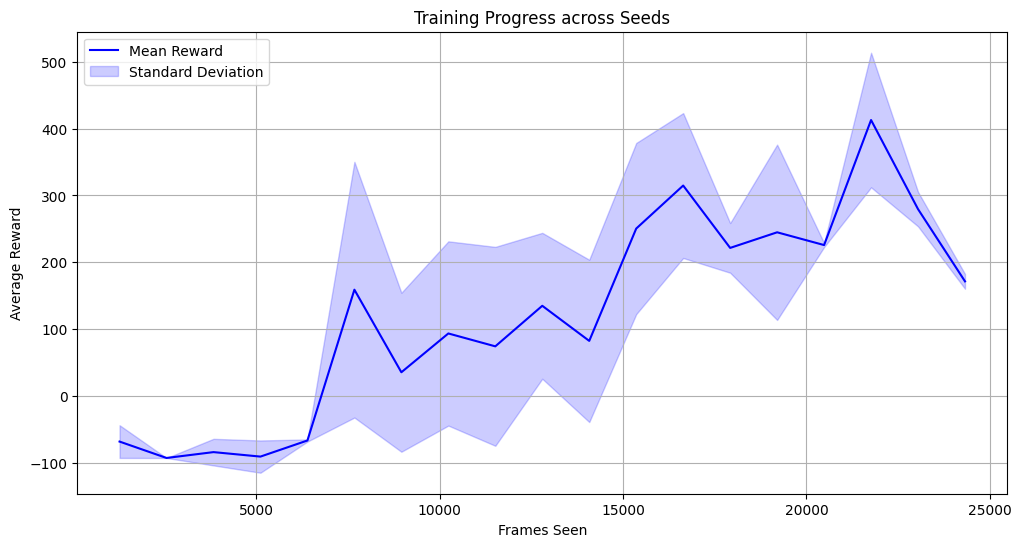

Generating GIF...
GIF saved as car_racing_agent.gif


In [ ]:
def plot_results(all_rewards, all_frames):
    # Ensure all reward lists have the same length for averaging
    # This can happen if runs terminate at slightly different frame counts
    min_len = min(len(rewards) for rewards in all_rewards)
    rewards_trimmed = [rewards[:min_len] for rewards in all_rewards]
    frames = all_frames[0][:min_len]

    rewards_np = np.array(rewards_trimmed)

    # Calculate mean and standard deviation across runs
    mean_rewards = np.mean(rewards_np, axis=0)
    std_rewards = np.std(rewards_np, axis=0)

    plt.figure(figsize=(12, 6))
    # Plot the mean reward line
    plt.plot(frames, mean_rewards, label='Mean Reward', color='blue')
    # Plot the standard deviation area
    plt.fill_between(frames, mean_rewards - std_rewards, mean_rewards + std_rewards, color='blue', alpha=0.2, label='Standard Deviation')

    plt.title('Training Progress across Seeds')
    plt.xlabel('Frames Seen')
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_results(all_runs_rewards, all_runs_frames)

### **9. Visualize Agent Performance (GIF)**

# Load the model from the first seed for visualization
trained_model = ImpalaCnn64(1, 5).to(device)
model_path = f"rl_model_seed_{seeds[0]}.pth"
trained_model.load_state_dict(torch.load(model_path, map_location=device))
trained_model.eval()

# Create a new env for the GIF
vis_env = gym.make(env_name, render_mode="rgb_array", lap_complete_percent=0.95, continuous=False)
frames = []

obs, _ = vis_env.reset()
done = False
print("Generating GIF...")

while not done:
    # Add the raw observation frame for the GIF
    frames.append(obs)
    state = state_to_tensor(obs, device).unsqueeze(0)

    with torch.no_grad():
        dist, _ = trained_model(state)
        action = torch.argmax(dist.probs).item() # Deterministic action

    obs, _, terminated, truncated, _ = vis_env.step(action)
    done = terminated or truncated

vis_env.close()

# Save the collected frames as a GIF
imageio.mimsave("car_racing_agent.gif", frames, fps=30)
print("GIF saved as car_racing_agent.gif")

# To display the GIF in Colab (optional)
# from IPython.display import Image
# Image(open('car_racing_agent.gif','rb').read())

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# def plot_results(all_rewards, all_frames):
#     # Ensure all reward lists have the same length for averaging
#     # This can happen if runs terminate at slightly different frame counts
#     min_len = min(len(rewards) for rewards in all_rewards)
#     rewards_trimmed = [rewards[:min_len] for rewards in all_rewards]
#     frames = all_frames[0][:min_len]

#     rewards_np = np.array(rewards_trimmed)

#     # Calculate mean and standard deviation across runs
#     mean_rewards = np.mean(rewards_np, axis=0)
#     std_rewards = np.std(rewards_np, axis=0)

#     plt.figure(figsize=(12, 6))
#     # Plot the mean reward line
#     plt.plot(frames, mean_rewards, label='mean reward', color='blue')
#     # Plot the standard deviation area
#     plt.fill_between(frames, mean_rewards - std_rewards, mean_rewards + std_rewards, color='blue', alpha=0.2, label='s.d')

#     plt.title('Training Progress across Seeds')
#     plt.xlabel('Frames Seen')
#     plt.ylabel('Average Reward')
#     plt.grid(True)
#     plt.legend()
#     plt.show()


# all_runs_rewards = [[100,200,300],[110,190,320],[90,190,310]]
# all_runs_frames = [[5,10,20],[5,10,20],[5,10,20]]
# plot_results(all_runs_rewards, all_runs_frames)

In [ ]:
obs, _ = vis_env.reset()
done = False
print("Generating GIF...")

while not done:
    # Add the raw observation frame for the GIF
    frames.append(obs)
    state = state_to_tensor(obs, device).unsqueeze(0)

    with torch.no_grad():
        dist, _ = trained_model(state)
        action = dist.sample().item()

    obs, _, terminated, truncated, _ = vis_env.step(action)
    done = terminated or truncated

vis_env.close()

# Save the collected frames as a GIF
imageio.mimsave("car_racing_agent.gif", frames, fps=30)
print("GIF saved as car_racing_agent.gif")

Generating GIF...
GIF saved as car_racing_agent.gif
